# Cycles

In [ ]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 19.3 MB/s eta 0:00:00


In [19]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [20]:
# Helper
def visualize_graph(graph):
    from IPython.display import Image, display
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

In [21]:
def add(left, right):
    return left + right


class State(TypedDict):
    total: Annotated[int, add]

In [88]:
builder = StateGraph(State)
builder.add_node('add_one', lambda x: {'total': 1})
builder.add_node('double', lambda x: {'total': x['total']})
builder.add_edge(START,'add_one')

def route(state: State) -> Literal['double', '__end__']:
  if state['total'] < 6:
    return 'double'
  return '__end__'

builder.add_conditional_edges("add_one", route)
builder.add_edge('double','add_one')

# graph = builder.compile()

memory = MemorySaver() # 15
graph = builder.compile(checkpointer=memory)

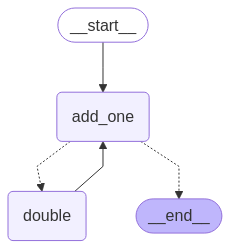

In [89]:
visualize_graph(graph)

In [90]:
thread_id = 'some-thread'
config = {'configurable' : {'thread_id': thread_id}}

graph.invoke({'total':1}, config, debug=True)

[-1:checkpoint] State at the end of step -1:
{'total': 0}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'total': 1}
[0:writes] Finished step 0 with writes to 1 channel:
- total -> 1
[0:checkpoint] State at the end of step 0:
{'total': 1}
[1:tasks] Starting 1 task for step 1:
- add_one -> {'total': 1}
[1:writes] Finished step 1 with writes to 1 channel:
- total -> 1
[1:checkpoint] State at the end of step 1:
{'total': 2}
[2:tasks] Starting 1 task for step 2:
- double -> {'total': 2}
[2:writes] Finished step 2 with writes to 1 channel:
- total -> 2
[2:checkpoint] State at the end of step 2:
{'total': 4}
[3:tasks] Starting 1 task for step 3:
- add_one -> {'total': 4}
[3:writes] Finished step 3 with writes to 1 channel:
- total -> 1
[3:checkpoint] State at the end of step 3:
{'total': 5}
[4:tasks] Starting 1 task for step 4:
- double -> {'total': 5}
[4:writes] Finished step 4 with writes to 1 channel:
- total -> 5
[4:checkpoint] State at the end of step 4:
{'total': 10}
[5:tasks] S

{'total': 11}

초기 상태	{'total': 1}	1  
"add_one" 실행	1 + 1 = 2	  
"double" 실행	2 + 2 = 4
"add_one" 실행	4 + 1 = 5
"double" 실행	5 + 5 = 10
"add_one" 실행	10 + 1 = 11   
종료 조건	11 >= 6 → 종료

#### 설명

1. 먼저, 그래프는 체크포인트를 찾습니다. 체크포인트가 발견되지 않으면 상태는 총계 0으로 초기화됩니다.
2. 다음으로, 그래프는 사용자의 입력을 상태 업데이트로 적용합니다. 리듀서는 입력 값(1)을 기존 값(0)에 추가합니다. 이 스텝의 끝에서 총계는 (1)이 됩니다.
3. 그 후, "add_one" 노드가 호출되어 1을 반환합니다.
4. 그 다음, 리듀서는 이 업데이트를 기존 총계(1)에 추가합니다. 상태는 이제 2입니다.
5. 그 다음, 조건부 에지 "route"가 호출됩니다. 값이 6보다 작으므로 'double' 노드로 이동합니다.
6. 'double'은 기존 상태(2)를 가져와 반환합니다. 리듀서가 호출되어 이를 기존 상태에 추가합니다. 상태는 이제 4가 됩니다.
7. 그래프는 다시 "add_one" (5)로 돌아가 조건부 에지를 확인하고, 값이 6보다 작으므로 계속 진행합니다. 'double' 노드를 거친 후 총계는 (10)이 됩니다.
8. 고정 에지는 다시 "add_one" (11)로 돌아가고, 조건부 엣지를 확인한 후 값이 6보다 크므로 프로그램이 종료됩니다.

이 과정을 통해 그래프는 사용자의 입력을 처리하고, 조건에 따라 다양한 노드를 통해 상태를 업데이트하며, 마지막에는 조건을 만족하지 않는 경우 프로그램이 종료됩니다.

# streaming

In [91]:
thread_id = "another-thread"
config = {"configurable": {"thread_id": thread_id}}

for step in graph.stream({"total": 1}, config):
    print(step)

{'add_one': {'total': 1}}
{'double': {'total': 2}}
{'add_one': {'total': 1}}
{'double': {'total': 5}}
{'add_one': {'total': 1}}


In [92]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'total': 11}, next=(), config={'configurable': {'thread_id': 'another-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f020c01-7827-6cc7-8005-8bffed2c4af1'}}, metadata={'source': 'loop', 'writes': {'add_one': {'total': 1}}, 'step': 5, 'parents': {}, 'thread_id': 'another-thread'}, created_at='2025-04-24T03:56:24.872249+00:00', parent_config={'configurable': {'thread_id': 'another-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f020c01-7826-65f9-8004-65e3a4bff751'}}, tasks=())

In [93]:
snapshot.values

{'total': 11}

In [94]:
thread_id = 'other-thread'
config = {'configurable': {'thread_id': thread_id}}

for step in graph.stream({'total':1}, config, stream_mode='debug'):
  print(step['step'], step['type'], step['payload'].get('values'))

-1 checkpoint {'total': 0}
0 checkpoint {'total': 1}
1 task None
1 task_result None
1 checkpoint {'total': 2}
2 task None
2 task_result None
2 checkpoint {'total': 4}
3 task None
3 task_result None
3 checkpoint {'total': 5}
4 task None
4 task_result None
4 checkpoint {'total': 10}
5 task None
5 task_result None
5 checkpoint {'total': 11}


In [95]:
for step in graph.stream({"total": -2, "turn": "First Turn"}, config, stream_mode="debug"):
    print(step["step"], step["type"], step["payload"].get("values"))

6 checkpoint {'total': 11}
7 checkpoint {'total': 9}
8 task None
8 task_result None
8 checkpoint {'total': 10}


11에서 -2를 줘서 9가 되고 리듀서에서 1을 입력받아 다시 10됨